# MLB data analysis 1: Using the career split data

In [297]:
import pandas as pd;
import numpy as np;

from matplotlib import pyplot as plt
plt.style.use('ggplot');
import scipy.stats as stats
import scipy as sp;

import seaborn as sns;

columns_career = ["ID", "Name", "Situation", "G", "AB", "R", "H", "2B", "3B", "HR", "RBI", "BB", "IBB", "SO", "HBP", "SH", \
                 "SF", "XI", "ROE", "GDP", "SB", "CS", "AVG", "OBP", "SLG"]; # len() = 25
columns_dtype = [str]*3 + [np.float64]*22;

columns_dtype_dict = dict(zip(columns_career, columns_dtype));

In [38]:
df_player_career_split = pd.read_csv("player_career_split_data.csv", usecols = columns_career, dtype = columns_dtype_dict);

## Testing if two binomial distributions are equal

We first formulate what we are trying to test. Suppose a batter's hitting average in non-RISP and RISP are $p_1$ and $p_2$, respectively, then our null hypothesis is

$$H_0: p_1 = p_2, \quad\text{ i.e. a batter is no stronger in clutch (RISP)}.$$

On the other hand, our alternative hypothesis is

$$H_A: p_1 < p_2, \quad\text{ i.e. a batter is stronger in clutch (RISP)}.$$

According to the literature (see, for instance, [here](https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other) for a stackoverflow discussion), there are two major ways to determined if the two binomial distributions are identical.

1. Approximate the binomial distribution to a normal distribution. Suppose the sample size is $N$, and the probability is $p$, then as a rule of thumb, the binomial distribution is "close enough" to a normal distribution only if $Np, N(1-p)$ are both about 10 or larger. Since in baseball $p < 0.5$, we requested $N > 30$ for a better approximation.

    For a player, if the AB of non-RISP and RISP are $N_1$ and $N_2$, respectively, then the weighted average is $\displaystyle \hat p = \frac{N_1p_1 + N_2p_2}{N_1 + N_2}$. Also, under the assumption that $p_1 = p_2$, one can estimate the variance of the distributions and obtain the $z$-value as
    
    $$z = \frac{\hat p_2 - \hat p_1}{\sqrt{\hat p(1-\hat p)\left(N_1^{-1} + N_2^{-1}\right)}}.$$
    
    By passing the $z$-value to the error function, once can obtain the one-sided $p$-value. See the NIST document at the end for more information.
    
2. Using the Fisher's exact test. First, we have to set up a $2\times2$ contingency matrix, which is
    $$\begin{bmatrix}\#\{\text{non-hits in non-RISP}\} & \#\{\text{non-hits in RISP}\} \\ \#\{\text{hits in non-RISP}\} & \#\{\text{hits in RISP}\}\end{bmatrix}.$$
    
    Fisher's idea is based on a model on hypergeobetric series, but we skip the details. Using the built-in function from scipy, we can compute an one-sided $p$-value.

Comparing methods 1 and 2, Fisher's test had no assumptions which approximates a binomial distribution as a normal distribution, so it can be appropriate for smaller sample size, but it becomes slow for larger sample size.

In [243]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "RISP"];
temp = temp[temp["AB"] >= AB_threshold];

RISP_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");
# RISP_comp.loc[0] # Total: 3771, 12364, 964, 2956
#.merge(df_player_career_split[df_player_career_split["Situation"] == "RISP"], on = "ID")


print(RISP_comp.shape[0]-1)


6995


### 2. The Fisher exact method

In [180]:
p_RISP = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res = stats.fisher_exact([[temp_list[1]-temp_list[3], temp_list[3]], \
                              [temp_list[0]-temp_list[2]-(temp_list[1]-temp_list[3]), temp_list[2]-temp_list[3]]], \
                             alternative="greater")[1];
    p_RISP.append(res);

### Tracing $p$-values throughout the player database

The assumption we are actually interested is:

*For every batter, the null hypothesis $H_0: p_\text{RISP} = p_\text{non-RISP}$ holds true*.

In this case, if we use either method above, the $p$-values computed by each player should be an uniform distribution in $[0,1]$. We can test this hypothesis using the $\chi$-squared test.

KstestResult(statistic=0.08506902691461204, pvalue=1.7046376806880028e-44)

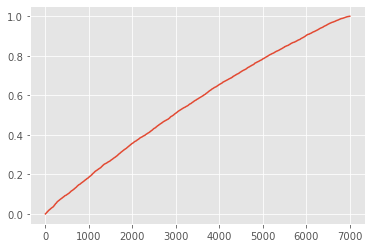

In [213]:
test = sorted(p_RISP)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) # 1.70e-44
# This means that the null hypothesis should be rejected... But wait?

(array([227., 282., 281., 282., 274., 328., 282., 343., 307., 337., 345.,
        346., 333., 384., 382., 389., 421., 434., 437., 582.]),
 array([2.96194432e-05, 5.00276629e-02, 1.00025706e-01, 1.50023750e-01,
        2.00021793e-01, 2.50019837e-01, 3.00017880e-01, 3.50015924e-01,
        4.00013967e-01, 4.50012011e-01, 5.00010054e-01, 5.50008098e-01,
        6.00006141e-01, 6.50004184e-01, 7.00002228e-01, 7.50000271e-01,
        7.99998315e-01, 8.49996358e-01, 8.99994402e-01, 9.49992445e-01,
        9.99990489e-01]),
 <BarContainer object of 20 artists>)

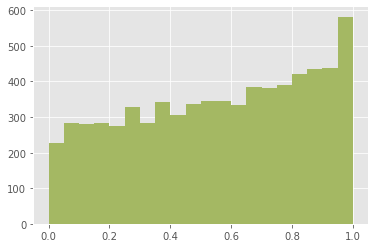

In [214]:
plt.hist(test, bins = 20, color = "#a4b863")

### It turns out that the hitting average at RISP is globally higher than at non-RISP. Can we adjust to that?

Unfortunately, things get a bit messy on that. I do not know of any rigorous mathematical model for that, but let's try...

In [222]:
# First idea: Try to multiply the AVG by a constant factor to balance the average in non-RISP and RISP.
# Equivalently, p_RISP = theta * p_nonRISP
test1 = [sum(RISP_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12715568, 3348091, 3022597, 802629

test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2633, .2655, .2626
#theta = test1[1]/test1[2]; # 1.0111716751056685
theta = 1.0111716751056685;

### Now, let us try to implement the method "1. Approximation to normal distribution"

In [223]:
def Phi(x): # The cdf of the normal distribution N(0,1).
    return (1+sp.special.erf(x/2**0.5))/2;

def Binomial_p_val(x1, x2, N1, N2, theta=0): # In our application, N1: non-RISP, N2: RISP
    p1 = x1/N1;
    p2 = x2/N2;
    if theta != 0:
        p2 = p2/theta;
    
    phat = (p1*N1 + p2*N2)/(N1 + N2);
    return Phi((p2-p1)/np.sqrt(phat*(1-phat)*(1/N1+1/N2)));

In [224]:
p_RISP_2 = [];
p_RISP_3 = [];
for i in range(RISP_comp.shape[0]):
    temp_list = RISP_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_RISP_2.append(res2);
    p_RISP_3.append(res3);

KstestResult(statistic=0.036174849581674495, pvalue=2.1700448058883414e-08)

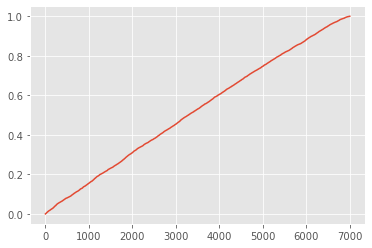

In [225]:
test = sorted(p_RISP_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([267., 371., 327., 298., 376., 293., 331., 360., 347., 322., 339.,
        332., 351., 341., 362., 356., 378., 372., 369., 504.]),
 array([4.28150841e-05, 5.00402498e-02, 1.00037684e-01, 1.50035119e-01,
        2.00032554e-01, 2.50029988e-01, 3.00027423e-01, 3.50024858e-01,
        4.00022293e-01, 4.50019727e-01, 5.00017162e-01, 5.50014597e-01,
        6.00012031e-01, 6.50009466e-01, 7.00006901e-01, 7.50004335e-01,
        8.00001770e-01, 8.49999205e-01, 8.99996639e-01, 9.49994074e-01,
        9.99991509e-01]),
 <BarContainer object of 20 artists>)

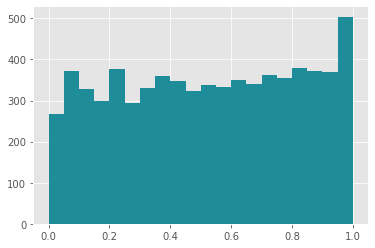

In [226]:
plt.hist(test, bins = 20, color = "#1f8c99")

KstestResult(statistic=0.013475397125518318, pvalue=0.1561262243686563)

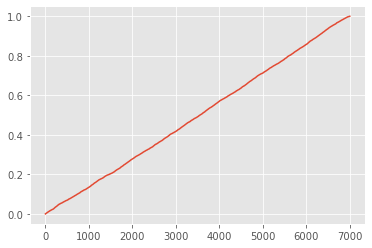

In [227]:
test = sorted(p_RISP_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([327., 407., 361., 368., 358., 346., 352., 336., 349., 348., 325.,
        346., 359., 308., 363., 341., 350., 322., 312., 418.]),
 array([3.41287437e-05, 5.00317866e-02, 1.00029444e-01, 1.50027102e-01,
        2.00024760e-01, 2.50022418e-01, 3.00020076e-01, 3.50017733e-01,
        4.00015391e-01, 4.50013049e-01, 5.00010707e-01, 5.50008365e-01,
        6.00006023e-01, 6.50003680e-01, 7.00001338e-01, 7.49998996e-01,
        7.99996654e-01, 8.49994312e-01, 8.99991969e-01, 9.49989627e-01,
        9.99987285e-01]),
 <BarContainer object of 20 artists>)

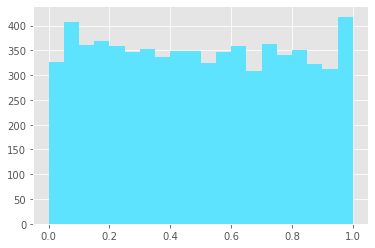

In [228]:
plt.hist(test, bins = 20, color = "#5ee3ff")

### Now this is the story of RISP, let us check out the other situations...

### Batting performance when there are men on base

In [408]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "Men On"];
temp = temp[temp["AB"] >= AB_threshold];

MenOn_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");
# RISP_comp.loc[0] # Total: 3771, 12364, 964, 2956
#.merge(df_player_career_split[df_player_career_split["Situation"] == "RISP"], on = "ID")


print(MenOn_comp.shape[0]-1) #7932


7932


In [409]:
# Finding the regression factor
test1 = [sum(MenOn_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12832445, 3370884, 5326841, 1434549
test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2627, .2693, .2579
print(test1)
theta = test1[1]/test1[2]; # 1.0111716751056685
# theta = 1.0438805477041186
print(theta);

[0.2626844689379148, 0.26930576677621876, 0.25798523343357843]
1.0438805477041186


In [410]:
p_MenOn_2 = [];
p_MenOn_3 = [];
for i in range(MenOn_comp.shape[0]):
    temp_list = MenOn_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_MenOn_2.append(res2);
    p_MenOn_3.append(res3);

KstestResult(statistic=0.11881777585785502, pvalue=4.8275052325738524e-98)

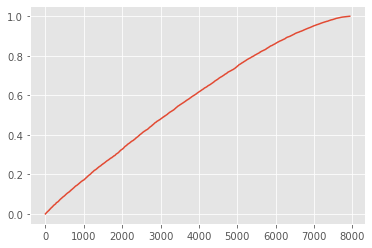

In [411]:
test = sorted(p_MenOn_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([262., 280., 312., 310., 317., 351., 299., 327., 334., 360., 340.,
        382., 380., 383., 383., 417., 436., 514., 590., 956.]),
 array([1.00237577e-04, 5.00952257e-02, 1.00090214e-01, 1.50085202e-01,
        2.00080190e-01, 2.50075178e-01, 3.00070166e-01, 3.50065154e-01,
        4.00060143e-01, 4.50055131e-01, 5.00050119e-01, 5.50045107e-01,
        6.00040095e-01, 6.50035083e-01, 7.00030071e-01, 7.50025059e-01,
        8.00020047e-01, 8.50015036e-01, 9.00010024e-01, 9.50005012e-01,
        1.00000000e+00]),
 <BarContainer object of 20 artists>)

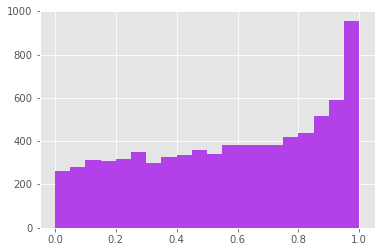

In [412]:
plt.hist(test, bins = 20, color = "#b241e9")

KstestResult(statistic=0.040749230467747366, pvalue=6.976218886226335e-12)

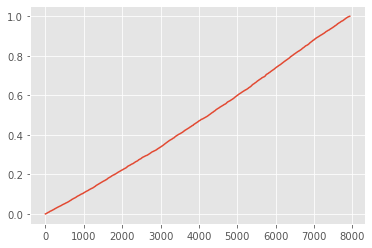

In [413]:
test = sorted(p_MenOn_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf) #
# This means that the null hypothesis should be rejected... But wait?

(array([483., 448., 448., 427., 427., 444., 408., 366., 403., 409., 367.,
        378., 369., 357., 347., 345., 353., 364., 397., 393.]),
 array([5.09751581e-05, 5.00484219e-02, 1.00045869e-01, 1.50043315e-01,
        2.00040762e-01, 2.50038209e-01, 3.00035655e-01, 3.50033102e-01,
        4.00030549e-01, 4.50027996e-01, 5.00025442e-01, 5.50022889e-01,
        6.00020336e-01, 6.50017782e-01, 7.00015229e-01, 7.50012676e-01,
        8.00010123e-01, 8.50007569e-01, 9.00005016e-01, 9.50002463e-01,
        9.99999909e-01]),
 <BarContainer object of 20 artists>)

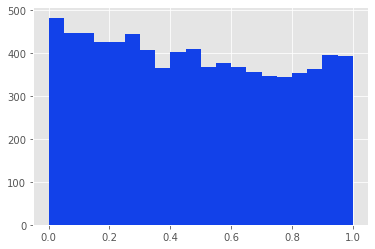

In [414]:
plt.hist(test, bins = 20, color = "#1241e9")

It turned out that using the batting data from the situation when there is runner on the base, there is a statitical significance between the normalized p-value and the uniform distribution on $(0,1)$.

### Batting performance in close and late situations

In [244]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "Close & Late"];
temp = temp[temp["AB"] >= AB_threshold];

CnL_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");

print(CnL_comp.shape[0]-1) #5909


5909


In [248]:
# Finding the regression factor
test1 = [sum(CnL_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #12456418, 3304112, 1959958, 503491
print(test1)
test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2653, .2569, .2668
print(test1)
# theta = test1[1]/test1[2]; # 0.9627941904139188
theta = 0.9627941904139188;

[12456418.0, 3304112.0, 1959958.0, 503491.0]
[0.26525378323046, 0.256888668022478, 0.26681576455300166]


0.9627941904139188

In [251]:
p_CnL_2 = [];
p_CnL_3 = [];
for i in range(CnL_comp.shape[0]):
    temp_list = CnL_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_CnL_2.append(res2);
    p_CnL_3.append(res3);

KstestResult(statistic=0.13703345362728642, pvalue=2.906318485046126e-97)

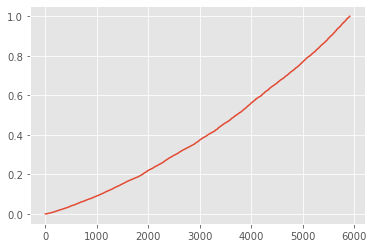

In [256]:
test = sorted(p_CnL_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)


(array([600., 479., 405., 401., 322., 312., 350., 284., 284., 268., 245.,
        247., 234., 255., 233., 215., 208., 201., 184., 183.]),
 array([3.93062695e-06, 5.00017451e-02, 9.99995596e-02, 1.49997374e-01,
        1.99995188e-01, 2.49993003e-01, 2.99990817e-01, 3.49988632e-01,
        3.99986446e-01, 4.49984261e-01, 4.99982075e-01, 5.49979890e-01,
        5.99977704e-01, 6.49975519e-01, 6.99973333e-01, 7.49971148e-01,
        7.99968962e-01, 8.49966777e-01, 8.99964591e-01, 9.49962405e-01,
        9.99960220e-01]),
 <BarContainer object of 20 artists>)

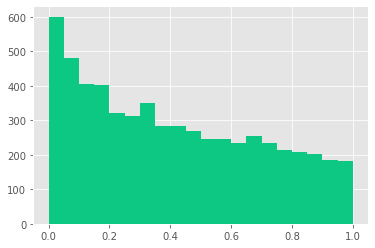

In [257]:
plt.hist(test, bins = 20, color = "#0dc883")

KstestResult(statistic=0.025072277809333576, pvalue=0.0011654972497789032)

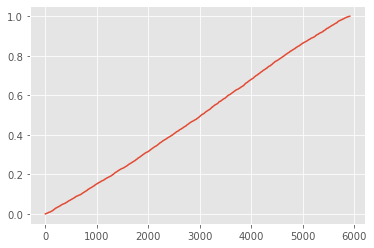

In [258]:
test = sorted(p_CnL_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)

(array([345., 351., 288., 334., 296., 283., 286., 286., 279., 280., 259.,
        262., 301., 241., 278., 265., 288., 322., 302., 364.]),
 array([4.26555520e-05, 5.00402647e-02, 1.00037874e-01, 1.50035483e-01,
        2.00033092e-01, 2.50030701e-01, 3.00028310e-01, 3.50025919e-01,
        4.00023528e-01, 4.50021138e-01, 5.00018747e-01, 5.50016356e-01,
        6.00013965e-01, 6.50011574e-01, 7.00009183e-01, 7.50006792e-01,
        8.00004401e-01, 8.50002011e-01, 8.99999620e-01, 9.49997229e-01,
        9.99994838e-01]),
 <BarContainer object of 20 artists>)

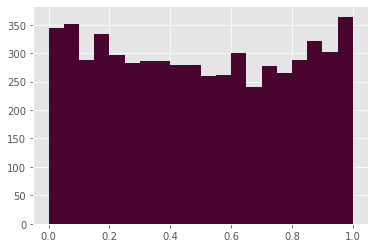

In [259]:
plt.hist(test, bins = 20, color = "#49042f")

Although it seems more uniform than the case when there are men on base, statistics still refutes the null hypothesis that the normalized $p$-values is indistinguishable to a uniform distribution.

### Batting performance when bases are loaded

In [260]:
AB_threshold = 30;

temp = df_player_career_split[df_player_career_split["Situation"] == "Bases Loaded"];
temp = temp[temp["AB"] >= AB_threshold];

BasesLoaded_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");

print(BasesLoaded_comp.shape[0]-1) #2780


2780


In [264]:
# Finding the regression factor
test1 = [sum(BasesLoaded_comp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]]; #10351603, 2803442, 232191, 66304
print(test1)
test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])]; #.2708, .2856, .2705
print(test1)
theta = test1[1]/test1[2] # 1.0557301668575974
theta = 1.0557301668575974;

[10351603.0, 2803442.0, 232191.0, 66304.0]
[0.27082201664804956, 0.28555801043106754, 0.2704838976810115]


In [319]:
p_BasesLoaded_2 = [];
p_BasesLoaded_3 = [];
for i in range(BasesLoaded_comp.shape[0]):
    temp_list = BasesLoaded_comp.loc[i, ["AB_x", "H_x", "AB_y", "H_y"]];
    res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
    res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
    p_BasesLoaded_2.append(res2);
    p_BasesLoaded_3.append(res3);

KstestResult(statistic=0.11651086442825875, pvalue=2.396877258226524e-33)

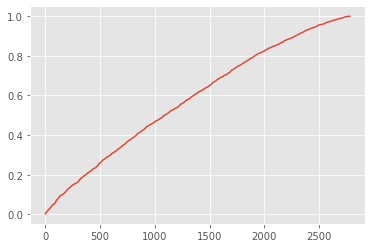

In [271]:
test = sorted(p_BasesLoaded_2)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)


(array([ 80.,  80., 101., 111., 113., 114., 118., 115., 119., 143., 136.,
        125., 145., 132., 136., 146., 179., 190., 195., 303.]),
 array([0.00189399, 0.05179898, 0.10170397, 0.15160896, 0.20151395,
        0.25141894, 0.30132393, 0.35122892, 0.40113391, 0.4510389 ,
        0.50094389, 0.55084888, 0.60075387, 0.65065885, 0.70056384,
        0.75046883, 0.80037382, 0.85027881, 0.9001838 , 0.95008879,
        0.99999378]),
 <BarContainer object of 20 artists>)

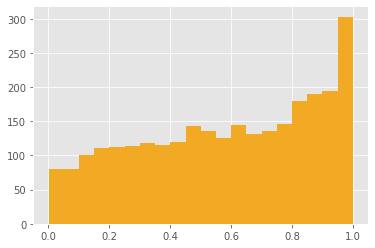

In [272]:
plt.hist(test, bins = 20, color = "#f2a923")

KstestResult(statistic=0.015143613606978024, pvalue=0.5413150248203669)

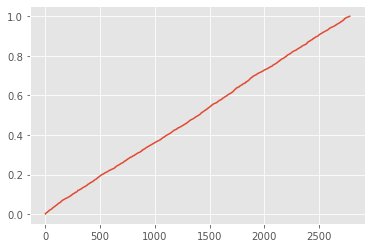

In [273]:
test = sorted(p_BasesLoaded_3)
plt.plot(test)

stats.kstest(test, stats.uniform(loc=0.0).cdf)


(array([114., 136., 139., 132., 155., 145., 147., 146., 149., 138., 120.,
        139., 125., 124., 166., 129., 143., 141., 149., 144.]),
 array([8.26689640e-04, 5.07822814e-02, 1.00737873e-01, 1.50693465e-01,
        2.00649057e-01, 2.50604649e-01, 3.00560240e-01, 3.50515832e-01,
        4.00471424e-01, 4.50427016e-01, 5.00382608e-01, 5.50338200e-01,
        6.00293791e-01, 6.50249383e-01, 7.00204975e-01, 7.50160567e-01,
        8.00116159e-01, 8.50071750e-01, 9.00027342e-01, 9.49982934e-01,
        9.99938526e-01]),
 <BarContainer object of 20 artists>)

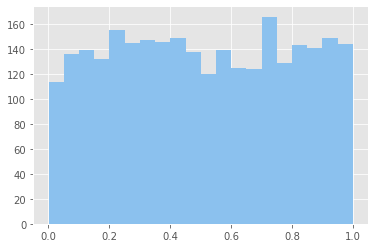

In [274]:
plt.hist(test, bins = 20, color = "#8bc1ee")

This one is flat.

### Storing the data, and move on

In [295]:
RISP_comp["p_RISP"] = p_RISP_3;
df_player_summary = df_player_career_split[df_player_career_split["Situation"] == "Total"];
df_player_summary = pd.merge(df_player_summary, RISP_comp[["ID", "p_RISP"]], on = "ID", how = "left");

MenOn_comp["p_MenOn"] = p_MenOn_3;
df_player_summary = pd.merge(df_player_summary, MenOn_comp[["ID", "p_MenOn"]], on = "ID", how = "left");

CnL_comp["p_CnL"] = p_CnL_3;
df_player_summary = pd.merge(df_player_summary, CnL_comp[["ID", "p_CnL"]], on = "ID", how = "left");

BasesLoaded_comp["p_BasesLoaded"] = p_BasesLoaded_3;
df_player_summary = pd.merge(df_player_summary, BasesLoaded_comp[["ID", "p_BasesLoaded"]], on = "ID", how = "left");

df_player_summary

,ID,Name,Situation,G,AB,R,H,2B,3B,HR,...,GDP,SB,CS,AVG,OBP,SLG,p_RISP,p_MenOn,p_CnL,p_BasesLoaded
0,0,David Aardsma,Total,331.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN
1,1,Hank Aaron,Total,3298.0,12364.0,2175.0,3771.0,624.0,98.0,755.0,...,330.0,240.0,73.0,0.305,0.374,0.555,0.993607,0.999918,0.996018,0.485484
2,2,Tommie Aaron,Total,437.0,944.0,102.0,216.0,42.0,6.0,13.0,...,37.0,9.0,8.0,0.229,0.291,0.327,0.522357,0.915248,0.704473,0.350849
3,3,Don Aase,Total,448.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN
4,4,Andy Abad,Total,15.0,21.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.095,0.240,0.095,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15997,19913,Bob Zupcic,Total,319.0,795.0,99.0,199.0,47.0,4.0,7.0,...,15.0,7.0,5.0,0.250,0.303,0.346,0.825106,0.974310,0.859930,NaN
15998,19914,Frank Zupo,Total,16.0,18.0,3.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.167,0.250,0.222,NaN,NaN,NaN,NaN
15999,19915,Paul Zuvella,Total,209.0,491.0,41.0,109.0,17.0,2.0,2.0,...,8.0,2.0,0.0,0.222,0.275,0.277,0.214693,0.339284,0.661780,NaN
16000,19916,George Zuverink,Total,266.0,141.0,5.0,21.0,2.0,1.0,0.0,...,3.0,0.0,0.0,0.149,0.200,0.177,0.468116,0.441874,0.939041,NaN


### As a quick recap, let us just see how these $p$-values correlate to each other

In [433]:
corr = df_player_summary[["p_RISP", "p_MenOn", "p_CnL", "p_BasesLoaded"]].corr();
corr

,p_RISP,p_MenOn,p_CnL,p_BasesLoaded
p_RISP,1.000000,0.618449,0.006156,0.272740
p_MenOn,0.618449,1.000000,0.020405,0.178911
p_CnL,0.006156,0.020405,1.000000,-0.025735
p_BasesLoaded,0.272740,0.178911,-0.025735,1.000000


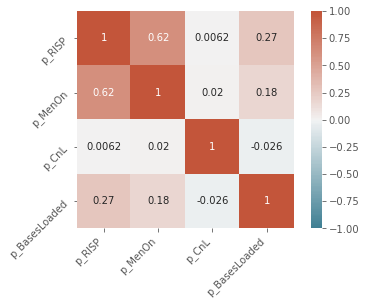

In [434]:
mask = np.triu(np.ones_like(corr)); # creating a upper triangular mask

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right');

A quick conclusion we can read from here is that the normalized $p$-values of the Close and Late situation seems to be very independent to the other three situations, where the lateness are not really taken into account.

In [310]:
df_player_summary[df_player_summary["AB"] > 5000].sort_values(by = "p_RISP", ascending = False)

,ID,Name,Situation,G,AB,R,H,2B,3B,HR,...,GDP,SB,CS,AVG,OBP,SLG,p_RISP,p_MenOn,p_CnL,p_BasesLoaded
15295,19034,Vic Wertz,Total,1862.0,6101.0,868.0,1692.0,289.0,42.0,266.0,...,144.0,9.0,22.0,0.277,0.364,0.469,0.999586,1.000000,0.996107,0.757469
5315,6670,Adrian Gonzalez,Total,1929.0,7139.0,997.0,2050.0,437.0,12.0,317.0,...,207.0,6.0,7.0,0.287,0.358,0.485,0.999455,0.999933,0.314016,0.956818
4421,5518,Tony Fernandez,Total,2158.0,7911.0,1057.0,2276.0,414.0,92.0,94.0,...,161.0,246.0,138.0,0.288,0.347,0.399,0.998739,0.999963,0.995968,0.470128
3995,4977,Leo Durocher,Total,1637.0,5350.0,575.0,1320.0,210.0,56.0,24.0,...,134.0,33.0,42.0,0.247,0.299,0.320,0.998316,0.999748,0.368227,0.200137
14116,17576,Mike Sweeney,Total,1454.0,5188.0,759.0,1540.0,325.0,5.0,215.0,...,142.0,53.0,25.0,0.297,0.366,0.486,0.996094,0.999996,0.161556,0.938265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,12768,Danny Murphy,Total,1474.0,5335.0,695.0,1543.0,288.0,103.0,44.0,...,0.0,189.0,0.0,0.289,0.336,0.407,NaN,NaN,NaN,NaN
13089,16276,Cy Seymour,Total,1319.0,5012.0,646.0,1537.0,216.0,91.0,44.0,...,0.0,209.0,0.0,0.307,0.355,0.412,NaN,NaN,NaN,NaN
13145,16357,Jimmy Sheckard,Total,1771.0,6332.0,1054.0,1716.0,296.0,105.0,45.0,...,0.0,344.0,0.0,0.271,0.376,0.372,NaN,NaN,NaN,NaN
14454,17994,Joe Tinker,Total,1809.0,6438.0,774.0,1690.0,264.0,114.0,31.0,...,0.0,339.0,2.0,0.263,0.308,0.353,NaN,NaN,NaN,NaN


## Investigating other batting data: OBP and SLG

Now, besides of the AVG, we also want to compute the $p$-values for the two other important classic factors, the OBP and SLG. They are computed as below.

- OBP  -  On-Base Percentage $\text{OBP} = \dfrac{\text{H} + \text{BB} + \text{HBP}}{\text{AB} + \text{BB} + \text{HBP} + \text{SF}}$
-
- SLG  -  Slugging Percentage $\text{SLG} = \dfrac{\text{H} + \text{2B} + 2\cdot\text{3B} + 3\cdot\text{HR}}{\text{AB}}$

Note that SLG is not a binary distribution, but we will also use the assumption that it approximates to a normal distribution as AB is large.

## The case of OBP

Found 8066 players with sufficient Men On data.
[14253874.0, 4701090.0, 6023258.0, 2053602.0]
[0.3298113902227563, 0.3409453820507108, 0.32166340891131356]
1.059944565049093


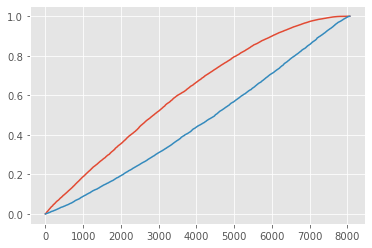

8.107660515791636e-218 4.722483439407669e-30
Found 7171 players with sufficient RISP data.
[14139470.0, 4672643.0, 3534714.0, 1236764.0]
[0.33046804441750643, 0.34989082567924873, 0.3239941588472191]
1.079929425037077


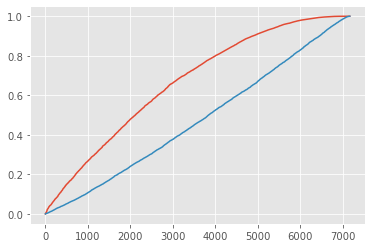

0.0 2.5116163610529775e-13
Found 6037 players with sufficient Close & Late data.
[13866709.0, 4613680.0, 2259782.0, 727089.0]
[0.33271629194785873, 0.32175183269890634, 0.33485099027503146]
0.9608806365919179


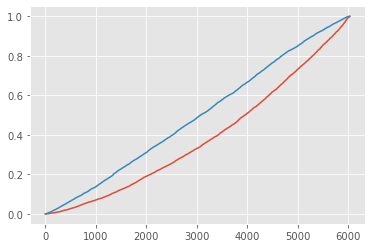

2.380574375493249e-151 8.41535173857555e-05
Found 2984 players with sufficient Bases Loaded data.
[11808705.0, 4002162.0, 326452.0, 89300.0]
[0.33891624864877223, 0.27354710646588165, 0.340774759099978]
0.8027211498537871


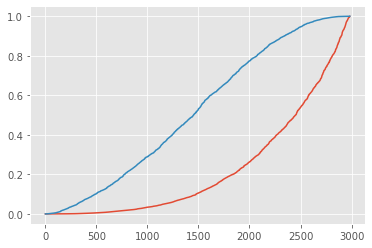

0.0 3.269887568265837e-39


In [386]:
df_player_career_split["SF"].fillna(0);

AB_threshold = 30;
measure_code = "OBP";

for situation_code in ["Men On", "RISP", "Close & Late", "Bases Loaded"]:
    temp = df_player_career_split[df_player_career_split["Situation"] == situation_code];
    temp = temp[temp["AB"]+temp["BB"]+temp["HBP"]+temp["SF"] >= AB_threshold];

    situation_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");

    print("Found " + str(situation_comp.shape[0]) + " players with sufficient " + situation_code + " data.");

    # Finding the regression factor
    situation_comp["AP_x"] = situation_comp["AB_x"] + situation_comp["BB_x"] + situation_comp["HBP_x"] + situation_comp["SF_x"];
    situation_comp["OB_x"] = situation_comp["H_x"] + situation_comp["BB_x"] + situation_comp["HBP_x"];
    situation_comp["AP_y"] = situation_comp["AB_y"] + situation_comp["BB_y"] + situation_comp["HBP_y"] + situation_comp["SF_x"];
    situation_comp["OB_y"] = situation_comp["H_y"] + situation_comp["BB_y"] + situation_comp["HBP_y"];


    test1 = [sum(situation_comp[item]) for item in ["AP_x", "OB_x", "AP_y", "OB_y"]];
    print(test1)
    test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])];
    print(test1)
    theta = test1[1]/test1[2];
    print(theta)

    p_situation_2 = [];
    p_situation_3 = [];
    for i in range(situation_comp.shape[0]):
        temp_list = situation_comp.loc[i, ["AP_x", "OB_x", "AP_y", "OB_y"]];
        res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
        res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
        p_situation_2.append(res2);
        p_situation_3.append(res3);    

    plt.plot(sorted(p_situation_2));
    plt.plot(sorted(p_situation_3));
    plt.show();

    print(stats.kstest(p_situation_2, stats.uniform(loc=0.0).cdf).pvalue, stats.kstest(p_situation_3, stats.uniform(loc=0.0).cdf).pvalue);
    # This is the Kolmogorov-Smirnov test, a built-in Scipy function, which measures the defiation between two distributions.
    
    # Update the dataframe
    situation_comp["p_"+situation_code+"_"+measure_code] = p_situation_3;
    df_player_summary = pd.merge(df_player_summary, situation_comp[["ID", "p_"+situation_code+"_"+measure_code]], \
                                 on = "ID", how = "left");


The interesting part on the OBP measure is that, this time the normalized $p$-value performed much worse than the AVG measure. My explanations are:
- When the regression ratio deviates much from 1 (say, not between 0.9 and 1.1), the linear regression is no longer accurate. Need to find a better model based on deeper statistics insights.
- Apart from the other three situations, when the bases are loaded, the OBP is much lower than the average. This might because many batters will attempt a sacrifice fly, which does not add to the OBP.

## The case of SLG

Note that we need to alternate the formula. The SLG metric is equivalent to compute the expected value of a discrete dristibution, where a 1B, 2B, 3B and HR scores 1, 2, 3, 4 points, respectively. Assuming that each trial is i.i.d., with a probability $p_i$ to earn a $i$-base hit ($i = 0, 1, 2, 3, 4$), the variance is
$$\sigma^2 = \sum_{i=0}^4 p_i(i-\mu)^2.$$

If there are $N$ trials, then the standard deviation of the SLG should be about $\displaystyle\sqrt{\frac1N\sum_{i=0}^4 p_i(i-\mu)^2}$.

In [374]:
def Discrete_p_val(x1, x2, N1, N2, theta=0): # In our application, N1: non-RISP, N2: RISP
    '''x1, x2 are lists of length 4, representing orrurences of 1B, 2B, 3B, HR
    N1, N2 are the AB in each case.
    theta is a global normalization factor, and theta = 0 means normalization is not applied.
    '''
    p1 = (x1[0]+x1[1]+x1[2]*2+x1[3]*3)/N1;
    p2 = (x2[0]+x2[1]+x2[2]*2+x2[3]*3)/N2;
    if theta != 0:
        p2 = p2/theta;
    
    x = [x1[i]+x2[i] for i in range(4)];
    N = N1 + N2;
    p = (x[0]+x[1]+x[2]*2+x[3]*3)/N;
    sigma2 = ((N-x[0]-x[1]-x[2]-x[3])*p**2 + x[0]*(1-p)**2 + x[1]*(2-p)**2 + x[2]*(3-p)**2 + x[3]*(4-p)**2)/N;
    
    return Phi((p2-p1)/np.sqrt(sigma2*(1/N1+1/N2)));

Found 7933 players with sufficient Men On data.
[12832445.0, 5061412.0, 5326841.0, 2148357.0]
[0.3944230425300868, 0.4033078892349143, 0.388117332062816]
1.0391390848003657


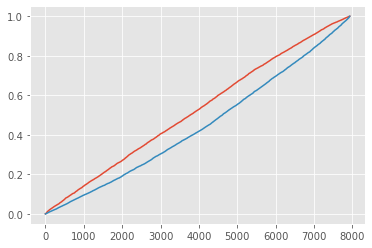

3.2560394162127407e-13 1.0710598569806276e-53
Found 6996 players with sufficient RISP data.
[12715568.0, 5031064.0, 3022597.0, 1203323.0]
[0.39566175887699234, 0.3981089771477971, 0.39489863324671043]
1.008129539154624


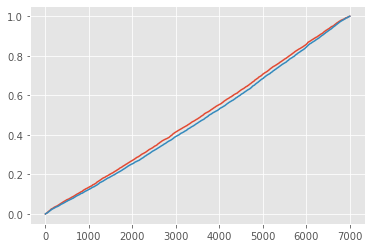

0.00999026407735957 3.154249091551762e-11
Found 5910 players with sufficient Close & Late data.
[12456418.0, 4973718.0, 1959958.0, 744306.0]
[0.39928958710280915, 0.3797560968143195, 0.40293699018526247]
0.9424701778799587


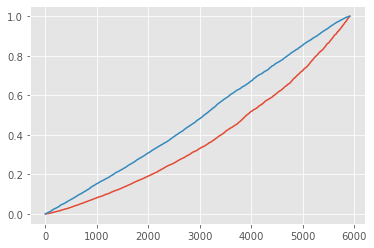

1.14988389200917e-168 2.3937611785585723e-06
Found 2781 players with sufficient Bases Loaded data.
[10351603.0, 4272606.0, 232191.0, 101918.0]
[0.41274824778345925, 0.4389403551386574, 0.41214726705464705]
1.0650085302651244


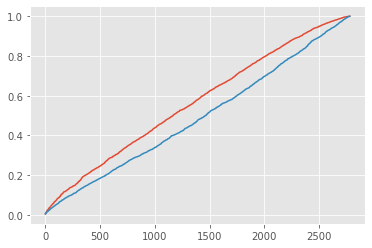

4.976066574921839e-18 0.007107382844940056


In [387]:

AB_threshold = 30;
measure_code = "SLG";

for situation_code in ["Men On", "RISP", "Close & Late", "Bases Loaded"]:
    temp = df_player_career_split[df_player_career_split["Situation"] == situation_code];
    temp = temp[temp["AB"] >= AB_threshold];

    situation_comp = pd.merge(df_player_career_split[df_player_career_split["Situation"] == "Total"], temp, on = "ID");

    print("Found " + str(situation_comp.shape[0]) + " players with sufficient " + situation_code + " data.");

    # Finding the regression factor
    situation_comp["SLG_x"] = situation_comp["H_x"] + situation_comp["2B_x"] + 2*situation_comp["3B_x"]\
                              + 3*situation_comp["HR_x"];
    situation_comp["SLG_y"] = situation_comp["H_y"] + situation_comp["2B_y"] + 2*situation_comp["3B_y"]\
                              + 3*situation_comp["HR_y"];


    test1 = [sum(situation_comp[item]) for item in ["AB_x", "SLG_x", "AB_y", "SLG_y"]];
    print(test1)
    ################ do things here mu_x = 1;
    test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])];
    print(test1)
    theta = test1[1]/test1[2];
    print(theta)

    p_situation_2 = [];
    p_situation_3 = [];
    for i in range(situation_comp.shape[0]):
        temp_list = situation_comp.loc[i, ["AB_x", "H_x", "2B_x", "3B_x", "HR_x", "AB_y", "H_y", "2B_y", "3B_y", "HR_y"]];
        x12 = temp_list[1:5];
        x2 = temp_list[6:10];
        x1 = list(map(lambda a, b:a-b, x12, x2));
        res2 = Discrete_p_val(x1, x2, temp_list[0]-temp_list[5], temp_list[5], 0);
        res3 = Discrete_p_val(x1, x2, temp_list[0]-temp_list[5], temp_list[5], theta);
        p_situation_2.append(res2);
        p_situation_3.append(res3);    

    plt.plot(sorted(p_situation_2));
    plt.plot(sorted(p_situation_3));
    plt.show();

    print(stats.kstest(p_situation_2, stats.uniform(loc=0.0).cdf).pvalue, stats.kstest(p_situation_3, stats.uniform(loc=0.0).cdf).pvalue);
    # This is the Kolmogorov-Smirnov test, a built-in Scipy function, which measures the defiation between two distributions.
    
    # Update the dataframe
    situation_comp["p_"+situation_code+"_"+measure_code] = p_situation_3;
    df_player_summary = pd.merge(df_player_summary, situation_comp[["ID", "p_"+situation_code+"_"+measure_code]], \
                                 on = "ID", how = "left");


In [388]:
len(p_situation_2)
#df_player_summary = df_player_summary.drop(["p_Men On_SLG", "p_RISP_SLG", "p_Close & Late_SLG", "p_Bases Loaded_SLG"], axis = 1);
df_player_summary

,ID,Name,Situation,G,AB,R,H,2B,3B,HR,...,p_CnL,p_BasesLoaded,p_Men On_OBP,p_RISP_OBP,p_Close & Late_OBP,p_Bases Loaded_OBP,p_Men On_SLG,p_RISP_SLG,p_Close & Late_SLG,p_Bases Loaded_SLG
0,0,David Aardsma,Total,331.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Hank Aaron,Total,3298.0,12364.0,2175.0,3771.0,624.0,98.0,755.0,...,0.996018,0.485484,0.976074,0.999979,0.999738,0.000912,0.518382,0.838178,0.994047,0.499496
2,2,Tommie Aaron,Total,437.0,944.0,102.0,216.0,42.0,6.0,13.0,...,0.704473,0.350849,0.653427,0.691731,0.735283,0.389768,0.844638,0.741218,0.750424,0.635720
3,3,Don Aase,Total,448.0,5.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Andy Abad,Total,15.0,21.0,1.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15997,19913,Bob Zupcic,Total,319.0,795.0,99.0,199.0,47.0,4.0,7.0,...,0.859930,NaN,0.741574,0.558932,0.847943,NaN,0.836183,0.849519,0.950190,NaN
15998,19914,Frank Zupo,Total,16.0,18.0,3.0,3.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15999,19915,Paul Zuvella,Total,209.0,491.0,41.0,109.0,17.0,2.0,2.0,...,0.661780,NaN,0.218037,0.172005,0.690515,NaN,0.370369,0.346852,0.694396,NaN
16000,19916,George Zuverink,Total,266.0,141.0,5.0,21.0,2.0,1.0,0.0,...,0.939041,NaN,0.282063,0.208580,0.948902,NaN,0.452945,0.604294,0.993411,NaN


There is an interesting "reverse normalization" phemenon on the first two situations, "Men on Bases" and "RISP". I am still trying to find an explantion on these two categories. It might be due to different batting strategies between scenarios.

## An analysis on the correlations between the normalized $p$-values and other factors

In [385]:
#df_player_summary.columns
# df_player_summary.drop(['p_Men On_OBP_x', 'p_RISP_OBP_x', 'p_Close & Late_OBP_x',
#        'p_Bases Loaded_OBP_x', 'p_Men On_OBP_y', 'p_RISP_OBP_y',
#        'p_Close & Late_OBP_y', 'p_Bases Loaded_OBP_y', 'p_Men On_OBP',
#        'p_RISP_OBP', 'p_Close & Late_OBP', 'p_Bases Loaded_OBP',
#        'p_Men On_SLG', 'p_RISP_SLG', 'p_Close & Late_SLG',
#        'p_Bases Loaded_SLG'], axis = 1, inplace=True)
df_player_summary

,ID,Name,Situation,G,AB,R,H,2B,3B,HR,...,GDP,SB,CS,AVG,OBP,SLG,p_RISP,p_MenOn,p_CnL,p_BasesLoaded
0,0,David Aardsma,Total,331.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN
1,1,Hank Aaron,Total,3298.0,12364.0,2175.0,3771.0,624.0,98.0,755.0,...,330.0,240.0,73.0,0.305,0.374,0.555,0.993607,0.999918,0.996018,0.485484
2,2,Tommie Aaron,Total,437.0,944.0,102.0,216.0,42.0,6.0,13.0,...,37.0,9.0,8.0,0.229,0.291,0.327,0.522357,0.915248,0.704473,0.350849
3,3,Don Aase,Total,448.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN
4,4,Andy Abad,Total,15.0,21.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.095,0.240,0.095,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15997,19913,Bob Zupcic,Total,319.0,795.0,99.0,199.0,47.0,4.0,7.0,...,15.0,7.0,5.0,0.250,0.303,0.346,0.825106,0.974310,0.859930,NaN
15998,19914,Frank Zupo,Total,16.0,18.0,3.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.167,0.250,0.222,NaN,NaN,NaN,NaN
15999,19915,Paul Zuvella,Total,209.0,491.0,41.0,109.0,17.0,2.0,2.0,...,8.0,2.0,0.0,0.222,0.275,0.277,0.214693,0.339284,0.661780,NaN
16000,19916,George Zuverink,Total,266.0,141.0,5.0,21.0,2.0,1.0,0.0,...,3.0,0.0,0.0,0.149,0.200,0.177,0.468116,0.441874,0.939041,NaN


In [391]:
df_player_summary.columns

Index(['ID', 'Name', 'Situation', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'XI', 'ROE', 'GDP', 'SB', 'CS',
       'AVG', 'OBP', 'SLG', 'p_RISP', 'p_MenOn', 'p_CnL', 'p_BasesLoaded',
       'p_Men On_OBP', 'p_RISP_OBP', 'p_Close & Late_OBP',
       'p_Bases Loaded_OBP', 'p_Men On_SLG', 'p_RISP_SLG',
       'p_Close & Late_SLG', 'p_Bases Loaded_SLG'],
      dtype='object')

In [435]:
corr = df_player_summary[["p_RISP", "p_RISP_OBP", "p_RISP_SLG", "p_MenOn", "p_Men On_OBP", "p_Men On_SLG",\
                          "p_CnL", "p_Close & Late_OBP", "p_Close & Late_SLG",\
                          "p_BasesLoaded", "p_Bases Loaded_OBP", "p_Bases Loaded_SLG"]].corr();
corr

,p_RISP,p_RISP_OBP,p_RISP_SLG,p_MenOn,p_Men On_OBP,p_Men On_SLG,p_CnL,p_Close & Late_OBP,p_Close & Late_SLG,p_BasesLoaded,p_Bases Loaded_OBP,p_Bases Loaded_SLG
p_RISP,1.000000,0.768852,0.836734,0.618449,0.495966,0.535757,0.006156,0.015195,0.016142,0.272740,0.196428,0.242478
p_RISP_OBP,0.768852,1.000000,0.634907,0.510053,0.687207,0.432215,-0.002580,0.049113,0.000319,0.217083,0.154243,0.177285
p_RISP_SLG,0.836734,0.634907,1.000000,0.511432,0.396789,0.634165,0.014473,0.025124,0.038906,0.234993,0.202415,0.301509
p_MenOn,0.618449,0.510053,0.511432,1.000000,0.820607,0.833685,0.020405,0.012458,0.024851,0.178911,0.020650,0.171993
p_Men On_OBP,0.495966,0.687207,0.396789,0.820607,1.000000,0.679093,-0.005503,0.025481,-0.009707,0.166506,0.011372,0.142173
p_Men On_SLG,0.535757,0.432215,0.634165,0.833685,0.679093,1.000000,0.024518,0.020569,0.044413,0.162223,0.074865,0.215300
p_CnL,0.006156,-0.002580,0.014473,0.020405,-0.005503,0.024518,1.000000,0.846875,0.842210,-0.025735,0.045713,-0.029023
p_Close & Late_OBP,0.015195,0.049113,0.025124,0.012458,0.025481,0.020569,0.846875,1.000000,0.725114,-0.044972,0.161810,-0.048594
p_Close & Late_SLG,0.016142,0.000319,0.038906,0.024851,-0.009707,0.044413,0.842210,0.725114,1.000000,-0.042259,0.091086,-0.021581
p_BasesLoaded,0.272740,0.217083,0.234993,0.178911,0.166506,0.162223,-0.025735,-0.044972,-0.042259,1.000000,0.553327,0.819063


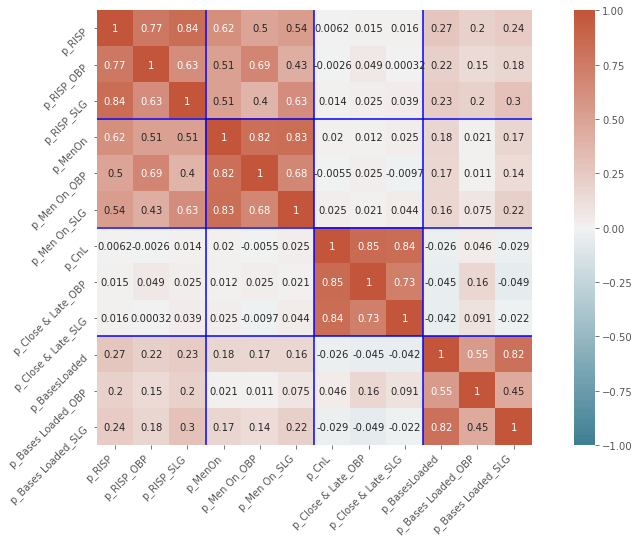

In [436]:
mask = np.triu(np.ones_like(corr)); # creating a upper triangular mask
mask = np.zeros_like(corr);
mask[np.triu_indices_from(mask)] = True;

plt.figure(figsize=(15,8))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right');
ax.hlines([3, 6, 9], *ax.get_xlim(), color = 'b');
ax.vlines([3, 6, 9], *ax.get_xlim(), color = 'b');


### Common classical metrics versus the normalized $p$-values

A first question to ask is: although we already delved into the relation between metrics generated from the three most common metrics: AVG, OPS, and SLG, are themselves actually relevant to the normalized $p$-values?

For a quick visualization, we 

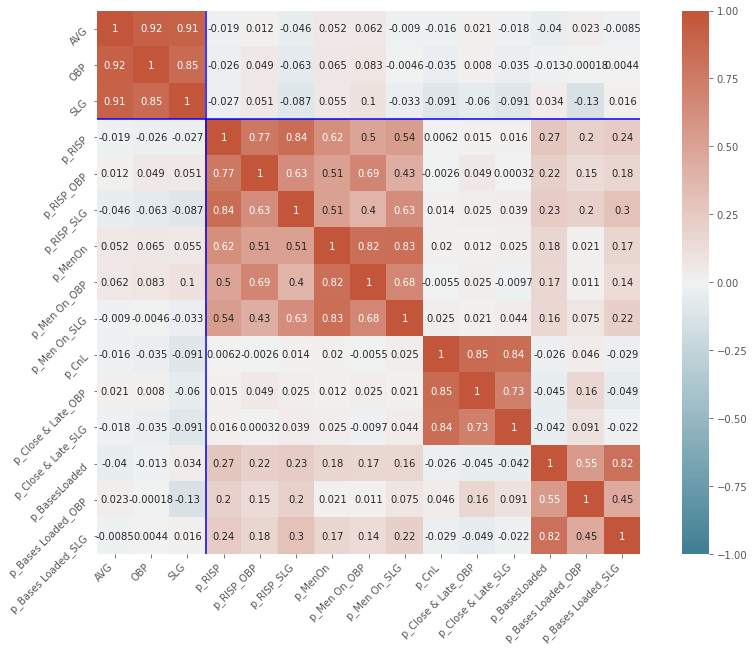

In [437]:
corr = df_player_summary[["AVG", "OBP", "SLG", "p_RISP", "p_RISP_OBP", "p_RISP_SLG", "p_MenOn", "p_Men On_OBP", "p_Men On_SLG",\
                          "p_CnL", "p_Close & Late_OBP", "p_Close & Late_SLG",\
                          "p_BasesLoaded", "p_Bases Loaded_OBP", "p_Bases Loaded_SLG"]].corr();
mask = np.triu(np.ones_like(corr)); # creating a upper triangular mask
mask = np.zeros_like(corr);
mask[np.triu_indices_from(mask)] = True;

plt.figure(figsize=(15,10))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right');
ax.hlines([3], *ax.get_xlim(), color = 'b');
ax.vlines([3], *ax.get_xlim(), color = 'b');


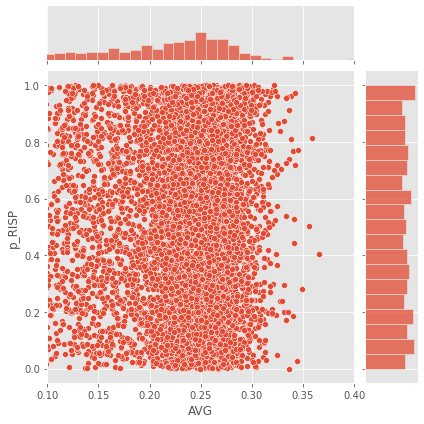

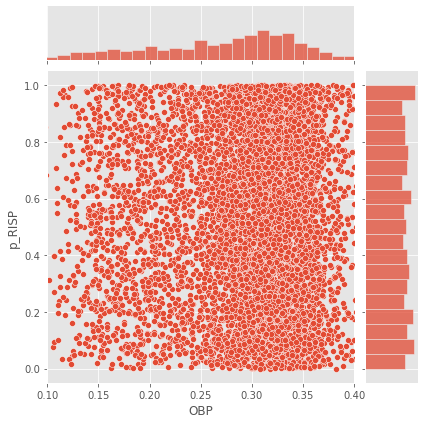

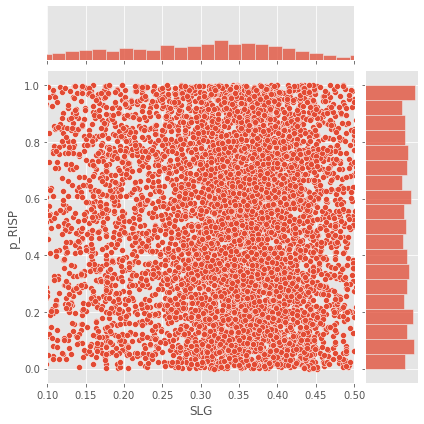

In [445]:
sns.jointplot(x = df_player_summary["AVG"], y = df_player_summary["p_RISP"], xlim=[0.1,0.4]);
sns.jointplot(x = df_player_summary["OBP"], y = df_player_summary["p_RISP"], xlim=[0.1,0.4]);
sns.jointplot(x = df_player_summary["SLG"], y = df_player_summary["p_RISP"], xlim=[0.1,0.5]);

### A plethora of (potentially) relevant factors:

The definitions are copied from Wikipedia.

- AB/HR: At bats per home run
- BABIP: Batting average on balls in play
- BB/PA: The frequency to get a walk
- BB/K: Number of walks per strike oup
- HR/H: Home runs per hit
- ISO: Isolated power: a hitter's ability to hit for extra bases, calculated by subtracting batting average from slugging percentage
- PA/SO: Plate appearances per strikeout: number of times a batter strikes out to their plate appearance
- OPS: On-base plus slugging: on-base percentage plus slugging average


In [455]:
df_player_summary["PA"] = df_player_summary["AB"] + df_player_summary["BB"] + df_player_summary["HBP"] + df_player_summary["SF"];
df_player_summary["AB/HR"] = df_player_summary["AB"] / df_player_summary["HR"];
df_player_summary["BABIP"] = (df_player_summary["H"] - df_player_summary["HR"])/(df_player_summary["AB"]-df_player_summary["SO"]-df_player_summary["HR"]+df_player_summary["SF"]);
df_player_summary["BB/PA"] = df_player_summary["BB"] / df_player_summary["PA"];
df_player_summary["BB/K"] = df_player_summary["BB"] / df_player_summary["SO"];
df_player_summary["HR/H"] = df_player_summary["HR"] / df_player_summary["H"];
df_player_summary["ISO"] = df_player_summary["SLG"] - df_player_summary["AVG"];
df_player_summary["PA/SO"] = df_player_summary["PA"] / df_player_summary["SO"];
df_player_summary["OPS"] = df_player_summary["OBP"] + df_player_summary["SLG"];

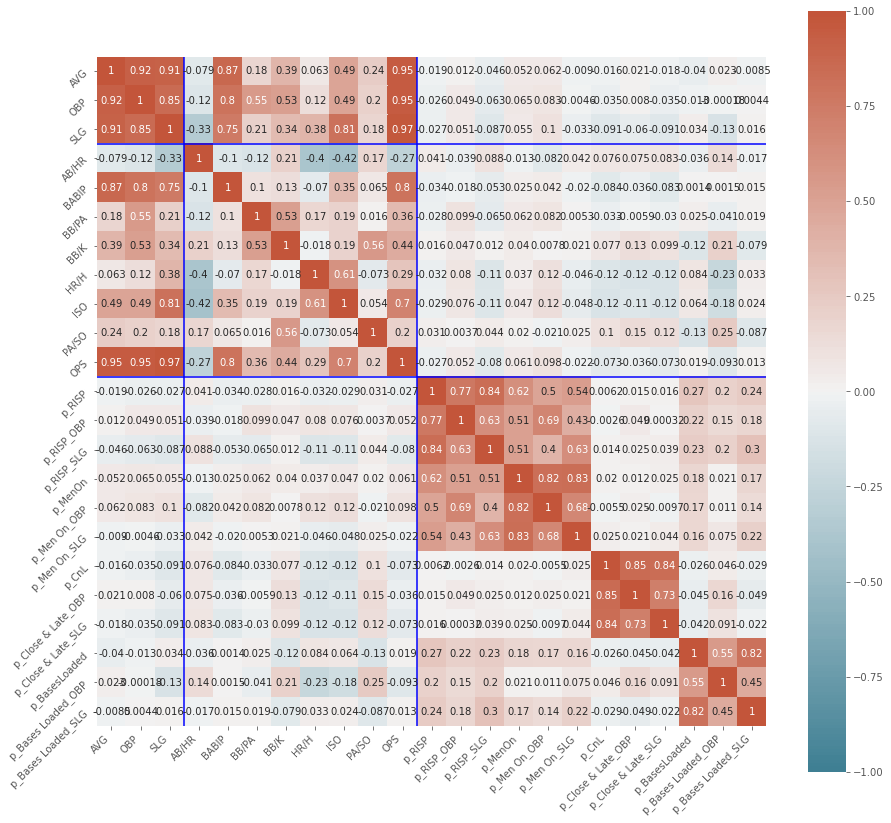

In [460]:
corr = df_player_summary[["AVG", "OBP", "SLG", "AB/HR", "BABIP", "BB/PA", "BB/K", "HR/H", "ISO", "PA/SO",\
                          "OPS", "p_RISP", "p_RISP_OBP", "p_RISP_SLG", "p_MenOn", "p_Men On_OBP", "p_Men On_SLG",\
                          "p_CnL", "p_Close & Late_OBP", "p_Close & Late_SLG",\
                          "p_BasesLoaded", "p_Bases Loaded_OBP", "p_Bases Loaded_SLG"]].corr();

mask = np.triu(np.ones_like(corr)); # creating a upper triangular mask
mask = np.zeros_like(corr);
mask[np.triu_indices_from(mask)] = True;

plt.figure(figsize=(15,14))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right');
ax.hlines([3,11], *ax.get_xlim(), color = 'b');
ax.vlines([3,11], *ax.get_xlim(), color = 'b');


## Clutch in groups

We can also try to compare the "clutch batting ability" by separating players into groups. We want to take a look at the following questions:
- Is there a difference between left-handed players, right-handed players, and switch hitters?
- Is there a difference between USA players and the internationals?
- Ar Hall of Famers better in clutch than the other players?

We will try to figure out these problems, by loading the `BIOFILE_MLB.csv` file, provided by retrosheet.

In [461]:
df_player_profile = pd.read_csv("BIOFILE_MLB.csv");

In [515]:
df_player_summary

,ID,Name,Situation,G,AB,R,H,2B,3B,HR,...,p_MenOn,PA,AB/HR,BABIP,BB/PA,BB/K,HR/H,ISO,PA/SO,OPS
0,0,David Aardsma,Total,331.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,4.0,inf,0.000000,0.000000,0.000000,NaN,0.000,2.000000,0.000
1,1,Hank Aaron,Total,3298.0,12364.0,2175.0,3771.0,624.0,98.0,755.0,...,0.766965,13920.0,16.376159,0.291429,0.100790,1.015930,0.200212,0.250,10.079652,0.929
2,2,Tommie Aaron,Total,437.0,944.0,102.0,216.0,42.0,6.0,13.0,...,0.748732,1035.0,72.615385,0.256313,0.082126,0.586207,0.060185,0.098,7.137931,0.618
3,3,Don Aase,Total,448.0,5.0,0.0,0.0,0.0,0.0,0.0,...,NaN,5.0,inf,0.000000,0.000000,0.000000,NaN,0.000,1.666667,0.000
4,4,Andy Abad,Total,15.0,21.0,1.0,2.0,0.0,0.0,0.0,...,NaN,25.0,inf,0.125000,0.160000,0.800000,0.000000,0.000,5.000000,0.335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15997,19913,Bob Zupcic,Total,319.0,795.0,99.0,199.0,47.0,4.0,7.0,...,0.893505,866.0,113.571429,0.291351,0.065820,0.416058,0.035176,0.096,6.321168,0.649
15998,19914,Frank Zupo,Total,16.0,18.0,3.0,3.0,1.0,0.0,0.0,...,NaN,20.0,inf,0.250000,0.100000,0.333333,0.000000,0.055,3.333333,0.472
15999,19915,Paul Zuvella,Total,209.0,491.0,41.0,109.0,17.0,2.0,2.0,...,0.194407,527.0,245.500000,0.243736,0.064516,0.680000,0.018349,0.055,10.540000,0.552
16000,19916,George Zuverink,Total,266.0,141.0,5.0,21.0,2.0,1.0,0.0,...,0.368939,150.0,inf,0.205882,0.060000,0.230769,0.000000,0.028,3.846154,0.377


In [509]:
#df_player_profile.columns # BATS, HOF, BIRTH COUNTRY
df_player_url = pd.read_csv("players_url.csv")
df_player_url["ID"] = df_player_url["Unnamed: 0"];
df_player_url.drop(["Unnamed: 0"], axis = 1, inplace=True);
df_player_url["Retro_id"] = df_player_url["Url"].str[-12:-4];
df_player_info = df_player_url.merge(df_player_profile[["PLAYERID","BATS", "HOF", "BIRTH COUNTRY"]], how = "left", left_on="Retro_id", right_on="PLAYERID");

In [511]:
#df_player_url.drop(["Retro_id"], axis = 1, inplace=True);
df_player_info["Domestic"] = df_player_info["BIRTH COUNTRY"] == "USA";

In [522]:
df_player_info["ID"] = df_player_info["ID"].astype(np.int64);
df_player_summary["ID"] = df_player_summary["ID"].astype(np.int64);
df_player_summary = df_player_summary.merge(df_player_info[["ID","BATS", "HOF", "Domestic"]], how = "left", on = "ID")

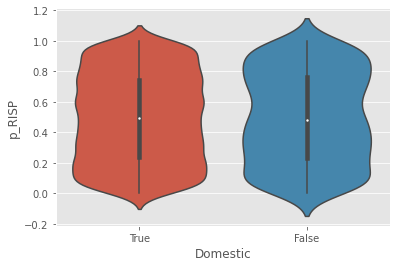

In [549]:
ax = sns.violinplot(x="Domestic", y="p_RISP", data=df_player_summary, order=[True, False]);


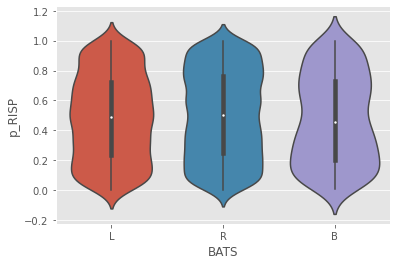

In [557]:
ax = sns.violinplot(x="BATS", y="p_RISP", data=df_player_summary, order=['L', 'R', 'B']); # Counts: R=10156, L=4442, B=1110

In [552]:
df_player_summary["HOF_batter"] = (df_player_summary["HOF"]=="HOF") & (df_player_summary["AB"] > 3000);
df_player_summary["HOF_batter"].value_counts(); #True = 148;

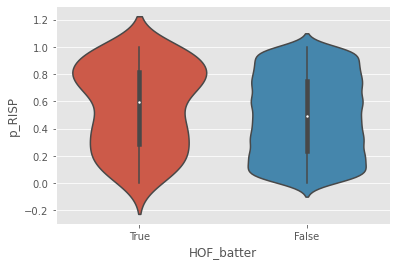

In [555]:
ax = sns.violinplot(x="HOF_batter", y="p_RISP", data=df_player_summary, order=[True, False]);

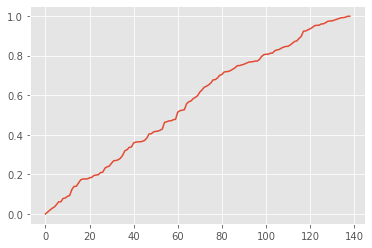

In [567]:
temp = sorted(df_player_summary[df_player_summary["HOF_batter"]]["p_RISP"].dropna());
plt.plot(temp)

## Babe versus Ruth: A self-testing approach to check the existence of clutch

Nate Silver proposed an interesting method to test whether the clutch effect exists:

1. For each player, split the AB into two equal halves. In Silver's article, he chosed even year versus odd year.
2. Among the entire player pool, see if the "clutch index" in the first half have a positive correlation to the "clutch index" of the second half.


In [609]:
columns_career2 = ["ID", "Name", "Season", "Team", "Situation", "G", "AB", "R", "H", "2B", "3B", "HR", "RBI",\
                  "BB", "IBB", "SO", "HBP", "SH", "SF", "XI", "ROE", "GDP", "SB", "CS", "AVG", "OBP", "SLG"];
columns_dtype = [str]*5 + [np.float64]*22;
columns_dtype_dict = dict(zip(columns_career2, columns_dtype));

df_player_season_split = pd.read_csv("player_season_split_data.csv", usecols = columns_career2, dtype = columns_dtype_dict);

In [610]:
df_player_season_split["Season"] = df_player_season_split["Season"].astype(np.int64);
df_player_even_split = df_player_season_split[df_player_season_split["Season"] % 2 == 0];
df_player_odd_split = df_player_season_split[df_player_season_split["Season"] % 2 != 0];

# df_player_even_split = df_player_season_split[""]

In [626]:
temp_even = df_player_even_split[df_player_even_split["Situation"]=="Total"]\
    [["ID", "Name", "Season", "Team", "Situation", "AB", "H"]].merge\
    (df_player_even_split[df_player_even_split["Situation"]=="RISP"]\
    [["ID", "Season", "Team", "Situation", "AB", "H"]], how = "inner", on = ["ID", "Season", "Team"]);
temp_odd  = df_player_odd_split[df_player_odd_split["Situation"]=="Total"]\
    [["ID", "Season", "Team", "Situation", "AB", "H"]].merge\
    (df_player_odd_split[df_player_odd_split["Situation"]=="RISP"]\
    [["ID", "Name", "Season", "Team", "Situation", "AB", "H"]], how = "inner", on = ["ID", "Season", "Team"]);


In [632]:
temp_even = temp_even.groupby(["ID", "Name"]).agg({"AB_x":"sum", "H_x":"sum", "AB_y":"sum", "H_y":"sum"})
temp_odd = temp_odd.groupby(["ID", "Name"]).agg({"AB_x":"sum", "H_x":"sum", "AB_y":"sum", "H_y":"sum"})

temp_even.reset_index(level=0, inplace=True); # Since "ID" and "Name" are now both in index, we need to reset twice.
temp_even.reset_index(level=0, inplace=True);
temp_odd.reset_index(level=0, inplace=True);
temp_odd.reset_index(level=0, inplace=True);

temp_even["ID"] = temp_even["ID"].astype(np.int64);
temp_odd["ID"] = temp_odd["ID"].astype(np.int64);

temp_even.sort_values("ID", ascending=True);
temp_odd.sort_values("ID", ascending=True);

Found 5556 players with sufficient RISP data.
[6006314.0, 1586140.0, 1482177.0, 394182.0]
[0.26407876777670963, 0.2659479940654861, 0.2634663804389655]
1.0094190902929852


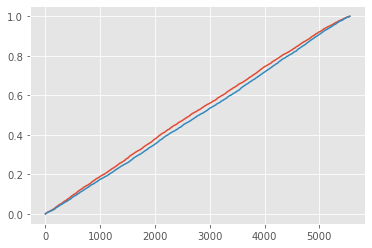

0.0013906896636517875 0.4834290596565677
Found 5734 players with sufficient RISP data.
[6116702.0, 1617058.0, 1497730.0, 400604.0]
[0.2643676281760988, 0.2674741108210425, 0.26336033212584964]
1.0156203429042876


<ipython-input-674-fd9298e6de45>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[column_name] = p_situation_3;


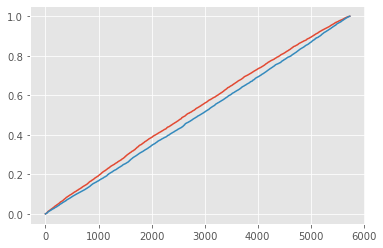

9.575495691095011e-09 0.6753961871759061


<ipython-input-674-fd9298e6de45>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[column_name] = p_situation_3;


In [674]:
AB_threshold = 30;
situation_code = "RISP";

par = 0;
for df in [temp_even, temp_odd]:
    df_temp = df[df["AB_y"] >= AB_threshold];

    print("Found " + str(df_temp.shape[0]) + " players with sufficient " + situation_code + " data.");

    test1 = [sum(df_temp[item]) for item in ["AB_x", "H_x", "AB_y", "H_y"]];
    print(test1);
    test1 = [test1[1]/test1[0], test1[3]/test1[2], (test1[1]-test1[3])/(test1[0]-test1[2])];
    print(test1);
    theta = test1[1]/test1[2];
    print(theta);

    p_situation_2 = [];
    p_situation_3 = [];
    for i in range(df_temp.shape[0]):
        temp_list = df_temp.iloc[i][["AB_x", "H_x", "AB_y", "H_y"]];
        res2 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], 0);
        res3 = Binomial_p_val(temp_list[1]-temp_list[3], temp_list[3], temp_list[0]-temp_list[2], temp_list[2], theta);
        p_situation_2.append(res2);
        p_situation_3.append(res3);    

    plt.plot(sorted(p_situation_2));
    plt.plot(sorted(p_situation_3));
    plt.show();

    print(stats.kstest(p_situation_2, stats.uniform(loc=0.0).cdf).pvalue, stats.kstest(p_situation_3, stats.uniform(loc=0.0).cdf).pvalue);
    # This is the Kolmogorov-Smirnov test, a built-in Scipy function, which measures the deviation between two distributions.

    # Update the dataframe
    column_name = "p_"+situation_code+"_"+str(par);
    df_temp[column_name] = p_situation_3;
    df_player_summary = pd.merge(df_player_summary, df_temp[["ID", column_name]], \
                                 on = "ID", how = "left");
    
    par = par + 1;


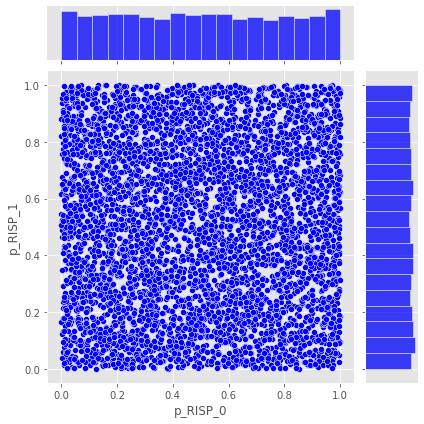

In [677]:
sns.jointplot(x = df_player_summary["p_RISP_0"], y = df_player_summary["p_RISP_1"], color = 'b');

In [681]:
df_player_summary[["p_RISP_0", "p_RISP_1"]].corr()

,p_RISP_0,p_RISP_1
p_RISP_0,1.000000,0.011765
p_RISP_1,0.011765,1.000000


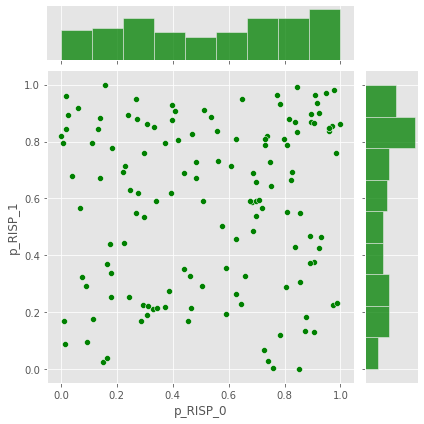

In [683]:
sns.jointplot(x = df_player_summary[df_player_summary["HOF_batter"]]["p_RISP_0"], y = df_player_summary[df_player_summary["HOF_batter"]]["p_RISP_1"], color = 'g');

In [685]:
df_player_summary[df_player_summary["HOF_batter"]][["p_RISP_0", "p_RISP_1"]].corr()

,p_RISP_0,p_RISP_1
p_RISP_0,1.000000,0.090269
p_RISP_1,0.090269,1.000000


In [304]:
df_player_summary[df_player_summary["Name"] == "Mark Grace"]

,ID,Name,Situation,G,AB,R,H,2B,3B,HR,...,GDP,SB,CS,AVG,OBP,SLG,p_RISP,p_MenOn,p_CnL,p_BasesLoaded
5431,6804,Mark Grace,Total,2245.0,8065.0,1179.0,2445.0,511.0,45.0,173.0,...,192.0,70.0,48.0,0.303,0.383,0.442,0.735907,0.999968,0.914197,0.97239


## Some statistical references

- How can we determine whether two processes produce the same proportion of defectives? From NIST
    https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm
- Fischer's exact test (have implementation in scipy)
    https://en.wikipedia.org/wiki/Fisher's_exact_test
- Barnard's test (have documentation in scipy, but the function seemed to be removed)
    https://en.wikipedia.org/wiki/Barnard%27s_test
